# Network Topology Visualization

Draws and prints information about the various network topologies in Cloudscope.

In [1]:
%matplotlib inline

import os
import sys
import json 
import numpy as np
import networkx as nx
import graph_tool.all as gt

from networkx.readwrite import json_graph

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.viz import draw_topology
from cloudscope.colors import ColorMap

In [2]:
FIXTURES = os.path.join("..", "deploy", "data")

def get_topologies(fixtures=FIXTURES):
    for name in os.listdir(fixtures):
        if name.endswith('.json'):
            yield os.path.join(fixtures, name)

            
def load_topology(path):
    with open(path, 'r') as f:
        data = json.load(f)
        G = json_graph.node_link_graph(data)
        return G, data['meta']

In [3]:
# Draw all the topologies
def print_topology(path, **kwargs):
    G, meta = load_topology(path)
    print meta['title']
    print meta['description']

    draw_topology(G, **kwargs)

In [4]:
# Show the Index
for path in get_topologies(): print path

../deploy/data/backbone.json
../deploy/data/bottleneck.json
../deploy/data/cluster.json
../deploy/data/division.json
../deploy/data/eventual.json
../deploy/data/hierarchy.json
../deploy/data/origin.json
../deploy/data/raft.json
../deploy/data/simulation.json
../deploy/data/tagging.json
../deploy/data/tiered.json
../deploy/data/workgroup.json


Backbone Simulation
A strong quroum backbone across locations, with causal work horses.


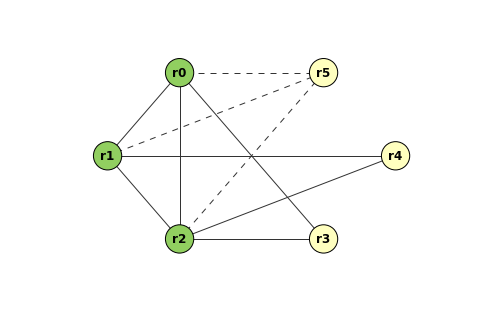

In [5]:
print_topology('../deploy/data/backbone.json')

Bottleneck Simulation
A causally consistent node that is a bottleneck between eventual and strong.


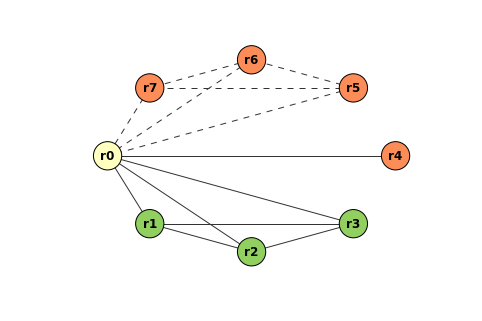

In [6]:
print_topology('../deploy/data/bottleneck.json')

Single Causal Cluster
Toplogy for single causal cluster experiments.


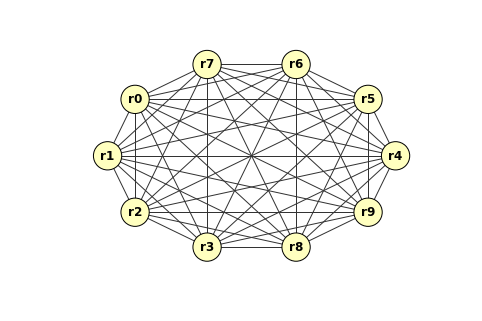

In [7]:
print_topology('../deploy/data/cluster.json')

Taking Sides
A topology with two strong sides, surrounded by eventual.


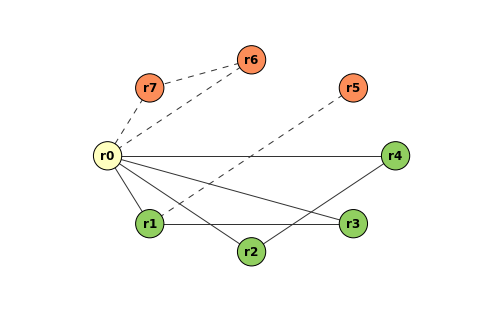

In [8]:
print_topology('../deploy/data/division.json')

Eventually There
Single Consistency Type: An Eventually Consistent Data Center.


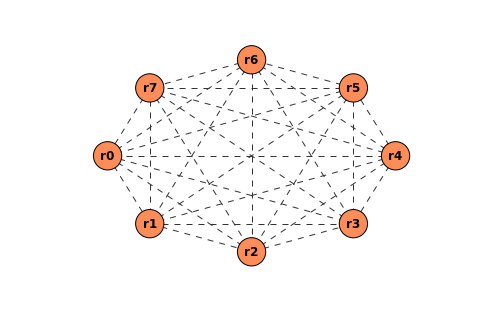

In [9]:
print_topology('../deploy/data/eventual.json')

Origin Simulation
An attempt at a realistic initial toplogy.


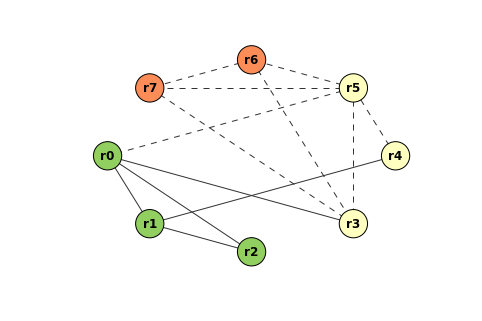

In [10]:
print_topology('../deploy/data/origin.json')

Raft Quorum
Single Consistency Type: Strong Raft Consensus.


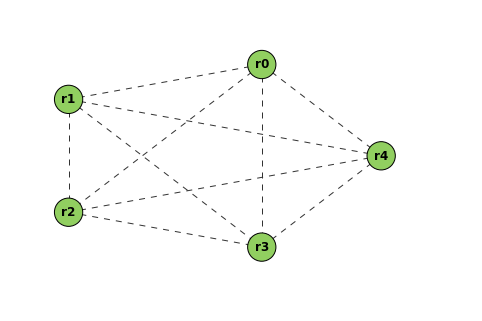

In [11]:
print_topology('../deploy/data/raft.json')

Origin Simulation
An attempt at a realistic initial toplogy.


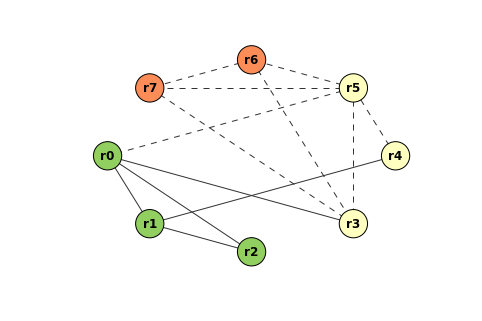

In [12]:
print_topology('../deploy/data/simulation.json')

Tagging Quorum
Single Consistency Type: Strong Tag Consensus.


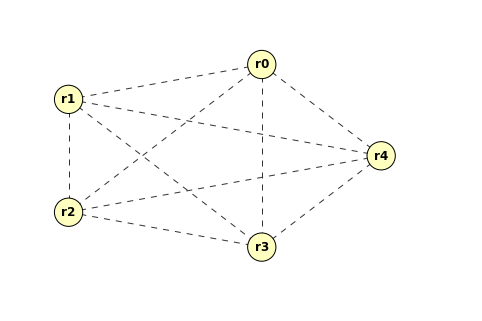

In [13]:
print_topology('../deploy/data/tagging.json')

Two Tier Quorums
A quorum of three quorums across a wide area.


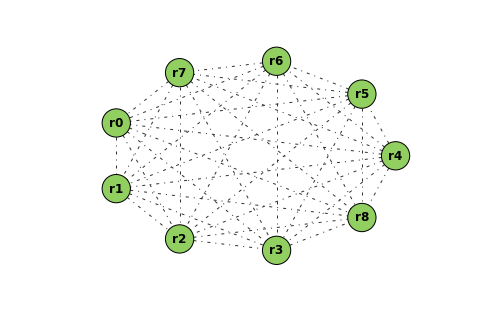

In [14]:
print_topology('../deploy/data/tiered.json')

Eventual/Strong Workgroup
Multiple eventual groups (users) progressing with a strong quroum to coordinate.


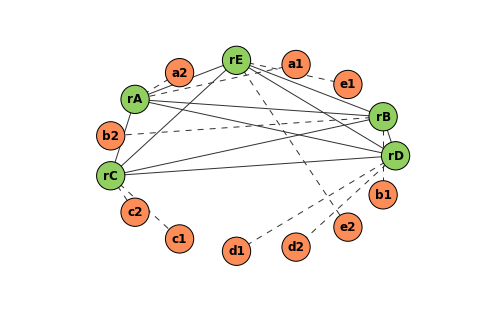

In [15]:
print_topology('../deploy/data/workgroup.json')

## Visualizing Communications 

In this section we will use the topology and messages from a results object to attempt to visualize the communication patterns among nodes. 

In [217]:
from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from collections import defaultdict

import graph_tool.all as gt
import numpy as np

In [219]:
RESULTS   = os.path.join("..", "fixtures", "results")
EVENTUAL  = os.path.join(RESULTS, "eventual.json")
FEDERATED = os.path.join(RESULTS, "federated.json")

def load_results(path):
    with open(path, 'r') as f:
        return Results.load(f)

results = load_results(FEDERATED)
G = extract_graph(results)
G.list_properties()

access_mean    (graph)   (type: double, val: 1200.0)
access_stddev  (graph)   (type: double, val: 180.0)
aggregate_heartbeats (graph)   (type: bool, val: 1)
aggregate_writes (graph)   (type: bool, val: 1)
anti_entropy_delay (graph)   (type: double, val: 2700.0)
constant       (graph)   (type: string, val: N/A ms)
count_messages (graph)   (type: bool, val: 1)
default_consistency (graph)   (type: string, val: strong)
default_latency (graph)   (type: double, val: 800.0)
default_replica (graph)   (type: string, val: storage)
description    (graph)   (type: string, val: A large group of eventually
                                             consistent nodes in 5 locations
                                             with a central core consensus
                                             group.)
do_gossip      (graph)   (type: bool, val: 1)
do_rumoring    (graph)   (type: bool, val: 0)
election_timeout (graph)   (type: string, val: [2700, 5400])
heartbeat_interval (graph)   (type: double

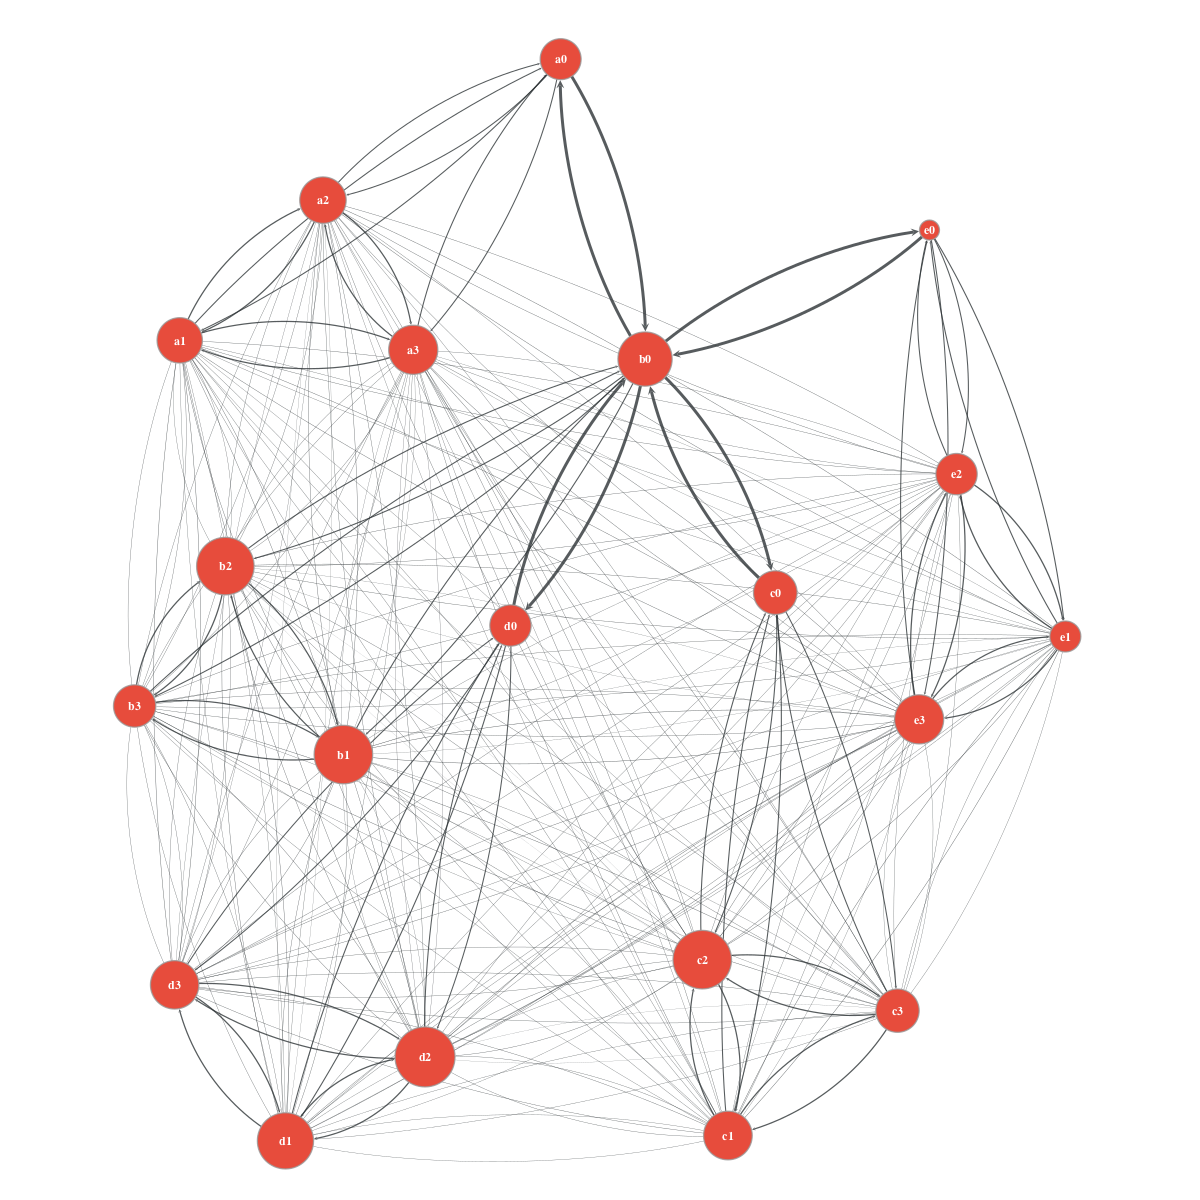

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x11c030750, at 0x10d0d8110>

In [218]:
get_color = ColorMap()

vlabel = G.vp['id']
vsize = G.vp['writes']
vsize = gt.prop_to_size(vsize, log=True, ma=60, mi=20)
esize = G.ep['norm']
esize = gt.prop_to_size(esize, mi=.1, ma=3)

eweight = G.ep['weight']

pos = gt.fruchterman_reingold_layout(G, weight=eweight)
gt.graph_draw(G, pos=pos, output_size=(1200,1200), output='/Users/benjamin/Desktop/eventual-network.png',
              vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
              vertex_pen_width=1.3, vertex_fill_color="#e74c3c",
              edge_pen_width=esize)

## Connection Visualization 

Visualizing the connections and locations of a topology. 

In [5]:
def load_gt_topology(path):
    # Create the Graph 
    G = gt.Graph(directed=False)
    
    # Add the graph properties 
    G.gp.title = G.new_graph_property('string')
    G.gp.description = G.new_graph_property('string')

    # Add the vertex properties 
    G.vp.id = G.new_vertex_property('string')
    G.vp.label = G.new_vertex_property('string')
    G.vp.type = G.new_vertex_property('string')
    G.vp.consistency = G.new_vertex_property('string')
    G.vp.location = G.new_vertex_property('string')
    
    # Add the edge properties 
    G.ep.connection = G.new_edge_property('string')
    G.ep.area = G.new_edge_property('string')
    G.ep.latency = G.new_edge_property('int')
    
    with open(path, 'r') as f:
        data = json.load(f)
        G.gp.title = data['meta']['title']
        G.gp.description = data['meta']['description']
        
        for node in data['nodes']:
            v = G.add_vertex()
            G.vp.id[v] = node['id']
            G.vp.label[v] = node['label']
            G.vp.type[v] = node['type']
            G.vp.consistency[v] = node['consistency']
            G.vp.location[v] = node['location']
        
        for edge in data['links']:
            src = G.vertex(edge['source'])
            dst = G.vertex(edge['target'])
            e = G.add_edge(src, dst) 
        
            G.ep.connection[e] = edge['connection']
            G.ep.area[e] = edge['area']
            
            if edge['connection'] == 'normal':
                G.ep.latency[e] = edge['latency'][0]
            elif edge['connection'] == 'variable':
                G.ep.latency[e] = sum(map(float, edge['latency'])) / len(edge['latency'])
            else:
                G.ep.latency[e] = edge['latency']
    
    return G

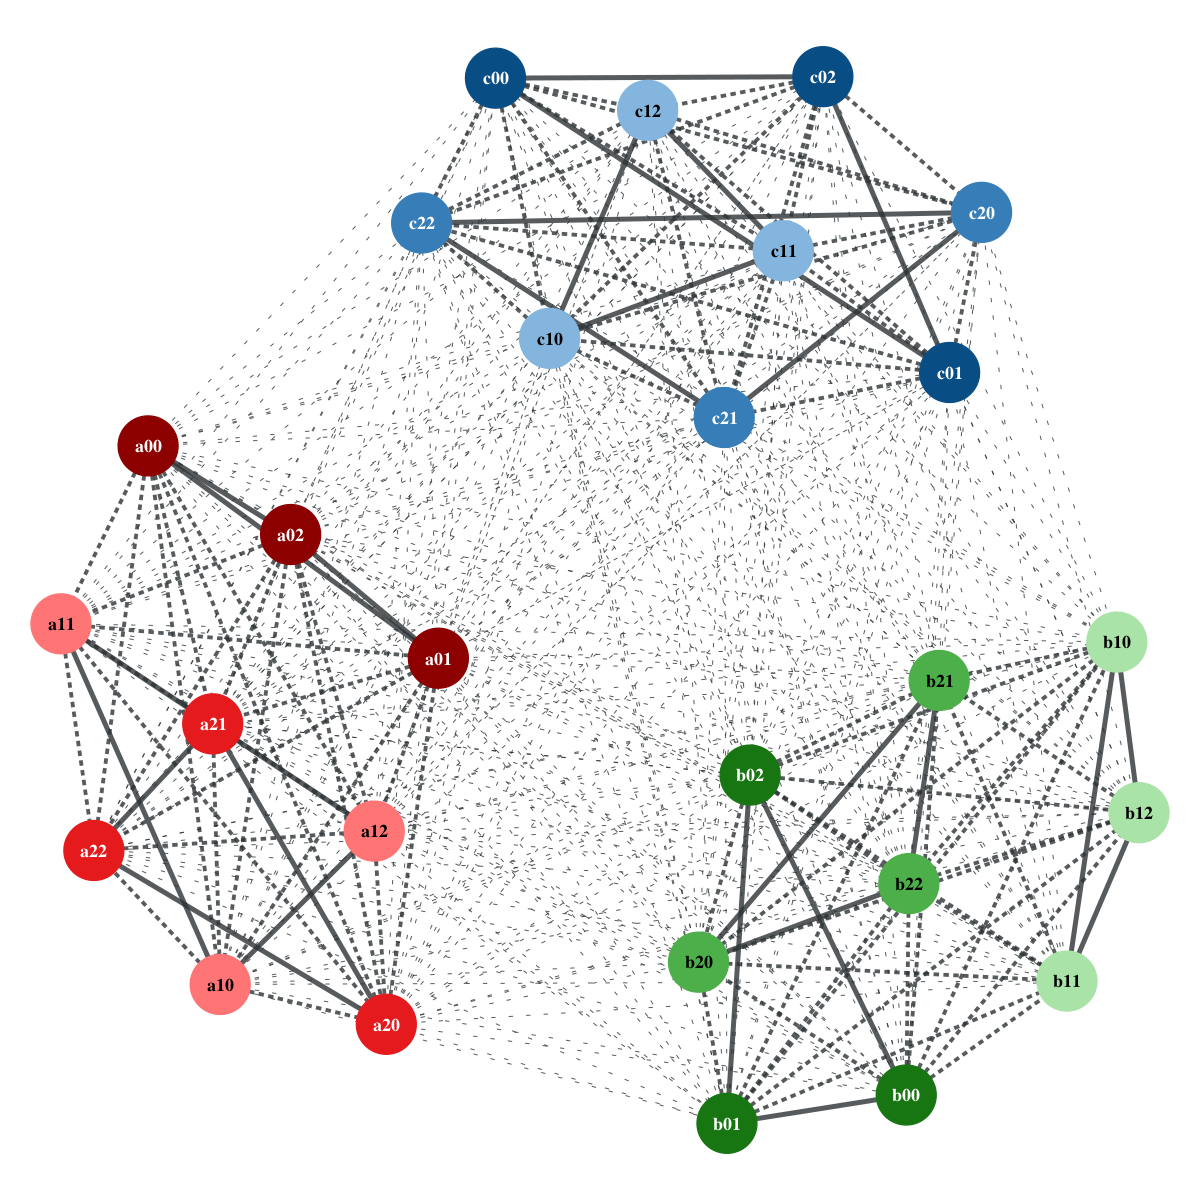

In [24]:
def draw_gt_topology(path):
    ## Load the topology 
    G = load_gt_topology(path)

    get_color = ColorMap(['#377eb8', '#84B5DE', '#094D85', '#4daf4a', '#AAE3A7', '#177512', '#e41a1c', '#FF7575', '#8C0000'])
    dotted = [0.002, 0.006, 0.]
    dashed = [0.0025, 0.002, 0.]
    solid  = [1., 0., 0.]

    
    esize  = G.new_edge_property('float') 
    edash  = G.new_edge_property('vector<float>')
    for e in G.edges():
        esize[e] = 1.0 / G.ep.latency[e]
        edash[e] = {
            'inner': solid, 
            'local': dashed,
            'wide': dotted,
        }[G.ep.area[e]]
        
        
    
    esize  = gt.prop_to_size(esize, mi=1, ma=5, log=True)

    vlabel = G.vp['id']
    vcolor = G.new_vertex_property('string')
    for v in G.vertices():
        vcolor[v] = get_color(G.vp['location'][v])
        
    title = G.gp.title.replace(' ', '-').lower()
    
    pos = gt.fruchterman_reingold_layout(G, weight=esize, grid=True)
    
    gt.graph_draw(G, pos=pos, output_size=(1200,1200), output='/Users/benjamin/Desktop/{}.png'.format(title),
                  vertex_text=vlabel, vertex_size=60, vertex_font_weight=1, vertex_font_size=18, 
                  vertex_pen_width=1.3, vertex_fill_color=vcolor, vertex_color=vcolor,
                  edge_pen_width=esize, edge_dash_style=edash)

    
    
draw_gt_topology("../deploy/data/hierarchy.json")